# Segmentation from original images

## IMPORTS

In [1]:
import os
import cv2
import torch
import random
import requests
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T

from tqdm import tqdm
from PIL import Image, ImageFilter
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.cuda.amp import autocast, GradScaler
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


## GLOBALS

Set *STREETVIEW* = *False* in order to generate segmentation from satellite images

In [10]:
STREETVIEW = False

In [4]:
if STREETVIEW:
    img_dir = r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\streetview"
else:
    img_dir = r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\bingmap"    

output_dir = r"C:\Users\fede6\Desktop\AI_R\DatasetCV\temp"
os.makedirs(output_dir, exist_ok=True)

## MODEL INITIALIZATION

In [5]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640", use_safetensors=True)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640", use_safetensors=True)
model.eval()

C:\Users\fede6\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\fede6\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

### Segmentation class reorganization

In [6]:
'''
1: building
25: house
48: skyscraper

2: sky

4: tree
17: plant

6: road
11: sidewalk
52: path

9: grass
13: earth
29: field
94: land

21: water
26: sea
60: river
128: lake

46: sand
'''

'\n1: building\n25: house\n48: skyscraper\n\n2: sky\n\n4: tree\n17: plant\n\n6: road\n11: sidewalk\n52: path\n\n9: grass\n13: earth\n29: field\n94: land\n\n21: water\n26: sea\n60: river\n128: lake\n\n46: sand\n'

In [7]:
target_classes_dict = {
    1:   (255, 192, 203),
    25:  (255, 192, 203),
    48:  (255, 192, 203),
    2:   (100, 149, 237),
    4:   (34, 139, 34),
    17:  (34, 139, 34),
    6:   (194, 197, 204),
    11:  (194, 197, 204),
    52:  (194, 197, 204),
    9:   (88, 57, 39),
    13:  (88, 57, 39),
    29:  (88, 57, 39),
    94:  (88, 57, 39),
    21:  (0, 163, 108),
    26:  (0, 163, 108),
    60:  (0, 163, 108),
    128: (0, 163, 108),
    46:  (250, 213, 165),
}

target_classes = list(target_classes_dict.keys())
print(target_classes)

[1, 25, 48, 2, 4, 17, 6, 11, 52, 9, 13, 29, 94, 21, 26, 60, 128, 46]


## GENERATION

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
for f in tqdm(os.listdir(img_dir), desc="Processing images"):
    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(img_dir, f)
        image = Image.open(img_path).convert('RGB')

        inputs = feature_extractor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            upsampled_logits = torch.nn.functional.interpolate(
                logits, size=image.size[::-1], mode='bilinear', align_corners=False
            )
            pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
            filtered_seg = np.where(np.isin(pred_seg, target_classes), pred_seg, 0)

        segmentation_color = np.zeros((filtered_seg.shape[0], filtered_seg.shape[1], 3), dtype=np.uint8)
        for class_id, color in target_classes_dict.items():
            mask = filtered_seg == class_id
            segmentation_color[mask] = color

        seg_pil = Image.fromarray(segmentation_color)

        save_path = os.path.join(output_dir, f"{os.path.splitext(f)[0]}_mask.png")
        seg_pil.save(save_path)


## VISUALIZATION

In [12]:
def show_images(path1, path2, titles=('title_1', 'title_2')):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    if img1 is None or img2 is None:
        raise FileNotFoundError("Image not found")

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title(titles[0])
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(titles[1])
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

### Satellite example

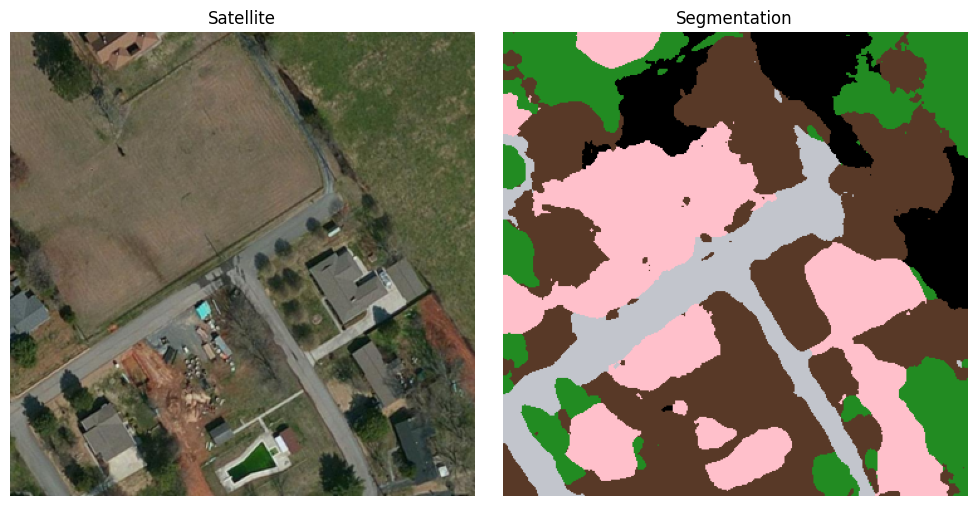

In [13]:
show_images(path1=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\bingmap\input0000052.png", path2=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\segformer\satellite\input0000052_mask.png", titles=('Satellite', 'Segmentation'))

### Streetview example

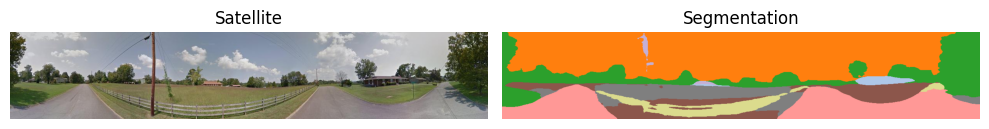

In [14]:
show_images(path1=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\streetview\0000052.jpg", path2=r"C:\Users\fede6\Desktop\AI_R\DatasetCV\CVUSA_subset\segformer\streetview\0000052_mask.png", titles=('Satellite', 'Segmentation'))